# fastlite

> A bit of extra usability for sqlite

- image: "images/diagram.png"

`fastlite` provides some little quality-of-life improvements for interactive use of the wonderful [sqlite-utils](https://sqlite-utils.datasette.io/) library. It's likely to be particularly of interest to folks using Jupyter.

## Install

```
pip install fastlite
```

## Overview

In [1]:
! pip install fastlite

In [2]:
from fastlite import *
from fastcore.utils import *
from fastcore.net import urlsave

We demonstrate `fastlite`'s features here using the 'chinook' sample database.

In [3]:
#| hide
Path('chinook.sqlite').unlink(missing_ok=True)
Path('chinook.sqlite-shm').unlink(missing_ok=True)
Path('chinook.sqlite-wal').unlink(missing_ok=True)

In [4]:
url = 'https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'
path = Path('chinook.sqlite')
if not path.exists(): urlsave(url, path)

db = database("chinook.sqlite")

Databases have a `t` property that lists all tables:

In [5]:
dt = db.t
dt

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

You can use this to grab a single table...:

In [6]:
artist = dt.artists
artist

<Table artists (does not exist yet)>

In [7]:
artist = dt.Artist
artist

<Table Artist (ArtistId, Name)>

...or multiple tables at once:

In [8]:
dt['Artist','Album','Track','Genre','MediaType']

[<Table Artist (ArtistId, Name)>,
 <Table Album (AlbumId, Title, ArtistId)>,
 <Table Track (TrackId, Name, AlbumId, MediaTypeId, GenreId, Composer, Milliseconds, Bytes, UnitPrice)>,
 <Table Genre (GenreId, Name)>,
 <Table MediaType (MediaTypeId, Name)>]

It also provides auto-complete in Jupyter, IPython, and nearly any other interactive Python environment:

![](attachment:image.png){width=180}

You can check if a table is in the database already:

In [9]:
'Artist' in dt

True

Column work in a similar way to tables, using the `c` property:

In [10]:
ac = artist.c
ac

ArtistId, Name

Auto-complete works for columns too:

![](attachment:image.png){width=140}

Columns, tables, and view stringify in a format suitable for including in SQL statements. That means you can use auto-complete in f-strings.

In [11]:
qry = f"select * from {artist} where {ac.Name} like 'AC/%'"
print(qry)

select * from "Artist" where "Artist"."Name" like 'AC/%'


You can view the results of a select query using `q`:

In [12]:
artist1 = db.q(qry)
artist1

[{'ArtistId': 1, 'Name': 'AC/DC'}]

In [13]:
artist_dc = artist.dataclass()
artist_dc

types.Artist

In [14]:
artist_obj = artist_dc(**artist1[0])
artist_obj

Artist(ArtistId=1, Name='AC/DC')

In [15]:
artist_obj.ArtistId

1

In [16]:
artist_obj.Name

'AC/DC'

Views can be accessed through the `v` property:

In [17]:
album = dt.Album

acca_sql = f"""select {album}.*
from {album} join {artist} using (ArtistId)
where {ac.Name} like 'AC/%'"""

db.create_view("AccaDaccaAlbums", acca_sql, replace=True)
acca_dacca = db.q(f"select * from {db.v.AccaDaccaAlbums}")
acca_dacca

[{'AlbumId': 1,
  'Title': 'For Those About To Rock We Salute You',
  'ArtistId': 1},
 {'AlbumId': 4, 'Title': 'Let There Be Rock', 'ArtistId': 1}]

## Dataclass support

A `dataclass` type with the names, types, and defaults of the tables is created using `dataclass()`:

In [18]:
album_dc = album.dataclass()

Let's try it:

In [19]:
album_obj = album_dc(**acca_dacca[0])
album_obj

Album(AlbumId=1, Title='For Those About To Rock We Salute You', ArtistId=1)

You can get the definition of the dataclass using fastcore's `dataclass_src` -- everything is treated as nullable, in order to handle auto-generated database values:

In [20]:
src = dataclass_src(album_dc)
hl_md(src, 'python')

```python
@dataclass
class Album:
    AlbumId: int | None = None
    Title: str | None = None
    ArtistId: int | None = None

```

Because `dataclass()` is dynamic, you won't get auto-complete in editors like vscode -- it'll only work in dynamic environments like Jupyter and IPython. For editor support, you can export the full set of dataclasses to a module, which you can then import from:

In [21]:
create_mod(db, 'db_dc')

In [22]:
#| eval: false
from db_dc import Track
Track()

Track(TrackId=None, Name=None, AlbumId=None, MediaTypeId=None, GenreId=None, Composer=None, Milliseconds=None, Bytes=None, UnitPrice=None)

Indexing into a table does a query on primary key:

In [23]:
dt.Track[1]

Track(TrackId=1, Name='For Those About To Rock (We Salute You)', AlbumId=1, MediaTypeId=1, GenreId=1, Composer='Angus Young, Malcolm Young, Brian Johnson', Milliseconds=343719, Bytes=11170334, UnitPrice=0.99)

There's a shortcut to select from a table -- just call it as a function. If you've previously called `dataclass()`, returned iterms will be constructed using that class by default. There's lots of params you can check out, such as `limit`:

In [24]:
album(limit=2)

[Album(AlbumId=1, Title='For Those About To Rock We Salute You', ArtistId=1),
 Album(AlbumId=2, Title='Balls to the Wall', ArtistId=2)]

Pass a truthy value as `with_pk` and you'll get tuples of primary keys and records:

In [25]:
album(with_pk=1, limit=2)

[(1,
  Album(AlbumId=1, Title='For Those About To Rock We Salute You', ArtistId=1)),
 (2, Album(AlbumId=2, Title='Balls to the Wall', ArtistId=2))]

Indexing also uses the dataclass by default:

In [26]:
album[5]

Album(AlbumId=5, Title='Big Ones', ArtistId=3)

If you set `xtra` fields, then indexing is also filtered by those. As a result, for instance in this case, nothing is returned since album 5 is not created by artist 1:

In [27]:
album.xtra(ArtistId=1)

try: album[5]
except NotFoundError: print("Not found")

Not found


The same filtering is done when using the table as a callable:

In [28]:
album()

[Album(AlbumId=1, Title='For Those About To Rock We Salute You', ArtistId=1),
 Album(AlbumId=4, Title='Let There Be Rock', ArtistId=1)]

## Core design

The following methods accept `**kwargs`, passing them along to the first `dict` param:

- `create`
- `transform`
- `transform_sql`
- `update`
- `insert`
- `upsert`
- `lookup`

We can access a table that doesn't actually exist yet:

In [29]:
cats = dt.cats
cats

<Table cats (does not exist yet)>

We can use keyword arguments to now create that table:

In [30]:
cats.create(id=int, name=str, weight=float, uid=int, pk='id')
hl_md(cats.schema, 'sql')

```sql
CREATE TABLE [cats] (
   [id] INTEGER PRIMARY KEY,
   [name] TEXT,
   [weight] FLOAT,
   [uid] INTEGER
)
```

It we set `xtra` then the additional fields are used for `insert`, `update`, and `delete`:

In [31]:
cats.xtra(uid=2)
cat = cats.insert(name='meow', weight=6)

The inserted row is returned, including the xtra 'uid' field.

In [32]:
cat

{'id': 1, 'name': 'meow', 'weight': 6.0, 'uid': 2}

Using `**` in `update` here doesn't actually achieve anything, since we can just pass a `dict` directly -- it's just to show that it works:

In [33]:
cat['name'] = "moo"
cat['uid'] = 1
cats.update(**cat)
cats()

[{'id': 1, 'name': 'moo', 'weight': 6.0, 'uid': 2}]

Attempts to update or insert with xtra fields are ignored.

An error is raised if there's an attempt to update a record not matching `xtra` fields:

In [34]:
cats.xtra(uid=1)
try: cats.update(**cat)
except NotFoundError: print("Not found")

Not found


This all also works with dataclasses:

In [35]:
cats.xtra(uid=2)
cats.dataclass()
cat = cats[1]
cat

Cats(id=1, name='moo', weight=6.0, uid=2)

In [36]:
cats.drop()
cats

<Table cats (does not exist yet)>

Alternatively, you can create a table from a class. If it's not already a dataclass, it will be converted into one. In either case, the dataclass will be created (or modified) so that `None` can be passed to any field (this is needed to support fields such as automatic row ids).

In [37]:
class Cat: id:int; name:str; weight:float; uid:int

In [38]:
cats = db.create(Cat)

In [39]:
hl_md(cats.schema, 'sql')

```sql
CREATE TABLE [cat] (
   [id] INTEGER PRIMARY KEY,
   [name] TEXT,
   [weight] FLOAT,
   [uid] INTEGER
)
```

In [40]:
cat = Cat(name='咪咪', weight=9)
cats.insert(cat)


Cat(id=1, name='咪咪', weight=9.0, uid=None)

In [41]:
cats.drop()

## Manipulating data

We try to make the following methods as flexible as possible. Wherever possible, they support Python dictionaries, dataclasses, and classes.

### .insert()

Creates a record. In the name of flexibility, we test that dictionaries, dataclasses, and classes all work. Returns an instance of the updated record.

Insert using a dictionary.

In [42]:
cats.insert({'name': 'Rex', 'weight': 12.2})

Cat(id=1, name='Rex', weight=12.2, uid=UNSET)

Insert using a dataclass.

In [43]:
CatDC = cats.dataclass()
cats.insert(CatDC(name='Tom', weight=10.2))

Cat(id=2, name='Tom', weight=10.2)

Insert using a standard Python class

In [44]:
cat = cats.insert(Cat(name='Jerry', weight=5.2))

### .update()

Updates a record using a Python dict, dataclasses, and classes all work and returns an instance of the updated record.

Updating from a Python dict:

In [45]:
cats.update(dict(id=cat.id, name='Jerry', weight=6.2))

Cat(id=3, name='Jerry', weight=6.2)

Updating from a dataclass:

In [46]:
cats.update(CatDC(id=cat.id, name='Jerry', weight=6.3))

Cat(id=3, name='Jerry', weight=6.3)

Updating using a class:

In [47]:
cats.update(Cat(id=cat.id, name='Jerry', weight=5.7))

Cat(id=3, name='Jerry', weight=5.7)

### .delete()

Removing data is done by providing the primary key value of the record.

In [48]:
# Farewell Jerry!
cats.delete(cat.id)

<Table cat (id, name, weight)>

### .lookup()

Looking up data is done by providing the dict of lookup value.

In [57]:
# cat_id = cats.lookup(lookup_values={'name': 'Tom'})
# cat_id = cats.lookup(lookup_values={'name': 'Tom', 'weight': 10.2})
cat_id = cats.lookup(lookup_values={'weight': 10.2})
cat_id

2

In [58]:
cat2 = cats[cat_id]
cat2

Cat(id=2, name='Tom', weight=10.2)

In [59]:
cat_id = cats.lookup(lookup_values={'name': 'Rex'})
cat_id

1

In [60]:
cat1 = cats[cat_id]
cat1

Cat(id=1, name='Rex', weight=12.2)

## Diagrams

If you have [graphviz](https://pypi.org/project/graphviz/) installed, you can create database diagrams:

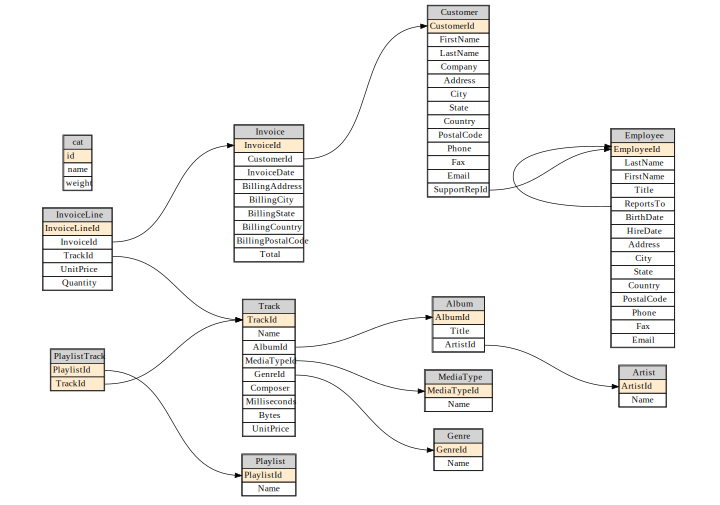

In [51]:
diagram(db.tables)

Pass a subset of tables to just diagram those. You can also adjust the size and aspect ratio.

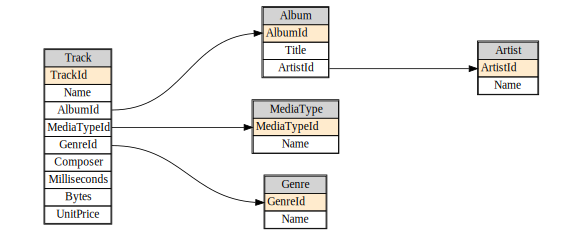

In [52]:
diagram(db.t['Artist','Album','Track','Genre','MediaType'], size=8, ratio=0.4)

## fin -